In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality, plot_acf
from darts.models import ExponentialSmoothing, ARIMA, RNNModel, TFTModel
from darts.utils.missing_values import fill_missing_values
from darts.metrics import mse, mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

2022-05-24 22:31:25 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.


In [3]:
import warnings
import logging
warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

In [4]:
dir_path = os.path.dirname(os.path.realpath("__file__"))
os.chdir(os.path.dirname(os.path.dirname(dir_path)))
os.getcwd()

'C:\\Users\\manash.jyoti.konwar\\Documents\\AI_Random_Projects\\Research-Catastrophic-Detection'

In [5]:
weather_data = pd.read_csv(r'rainfall_prediction\data\jennings_ghcnd.csv', parse_dates=['DATE'])
weather_data = weather_data[['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'EVAP',
            'MNPN', 'MXPN', 'PRCP', 'SN32', 'SN52', 'SNOW', 'SNWD', 'SX52', 'TMAX',
            'TMIN', 'TOBS', 'WDMV']]
weather_data.shape

(4473, 19)

In [6]:
weather_data['YEAR'] = weather_data['DATE'].apply(lambda x: x.year)
weather_data['MONTH'] = weather_data['DATE'].apply(lambda x: x.month)
weather_data['PRCP_mm'] = weather_data['PRCP'].apply(lambda x: x*25.4)

In [7]:
weather_data = weather_data.groupby(['YEAR','MONTH']).agg({'PRCP_mm':'mean'}).reset_index()
weather_data['DAY'] = 1
weather_data['DATE'] = pd.to_datetime(weather_data[['YEAR','MONTH','DAY']])
weather_data

,YEAR,MONTH,PRCP_mm,DAY,DATE
0,2010,1,2.023806,1,2010-01-01
1,2010,2,5.288643,1,2010-02-01
2,2010,3,1.524000,1,2010-03-01
3,2010,4,0.821267,1,2010-04-01
4,2010,5,2.671097,1,2010-05-01
...,...,...,...,...,...
142,2021,12,2.228645,1,2021-12-01
143,2022,1,1.786194,1,2022-01-01
144,2022,2,0.689429,1,2022-02-01
145,2022,3,2.294194,1,2022-03-01


In [8]:
missing_month = {
    'YEAR': 2020, 
    'MONTH': 6, 
    'PRCP_mm': weather_data.loc[weather_data.YEAR.isin([2020])].PRCP_mm.mean(),
    'DAY': 1, 
    'DATE': pd.to_datetime('2020-06-01')
}
weather_data = weather_data.append(missing_month, ignore_index = True)
weather_data.sort_values(by='DATE', ascending=True, inplace=True)
weather_data

,YEAR,MONTH,PRCP_mm,DAY,DATE
0,2010,1,2.023806,1,2010-01-01
1,2010,2,5.288643,1,2010-02-01
2,2010,3,1.524000,1,2010-03-01
3,2010,4,0.821267,1,2010-04-01
4,2010,5,2.671097,1,2010-05-01
...,...,...,...,...,...
142,2021,12,2.228645,1,2021-12-01
143,2022,1,1.786194,1,2022-01-01
144,2022,2,0.689429,1,2022-02-01
145,2022,3,2.294194,1,2022-03-01


## Data Sampling

In [9]:
# weather_data = weather_data.loc[weather_data.YEAR.isin([2019, 2020, 2021, 2022])].reset_index(drop=True)

In [10]:
weather_data

,YEAR,MONTH,PRCP_mm,DAY,DATE
0,2010,1,2.023806,1,2010-01-01
1,2010,2,5.288643,1,2010-02-01
2,2010,3,1.524000,1,2010-03-01
3,2010,4,0.821267,1,2010-04-01
4,2010,5,2.671097,1,2010-05-01
...,...,...,...,...,...
142,2021,12,2.228645,1,2021-12-01
143,2022,1,1.786194,1,2022-01-01
144,2022,2,0.689429,1,2022-02-01
145,2022,3,2.294194,1,2022-03-01


In [11]:
series = TimeSeries.from_dataframe(weather_data, 'DATE', 'PRCP_mm', fill_missing_dates=True, freq='MS')
# series = fill_missing_values(series)

In [12]:
round(len(series)*0.75,0)

111.0

In [13]:
train_index = int(len(series)) - int(round(len(series)*0.75,0))
train_series, val_series = series[:-train_index+1], series[-train_index:]

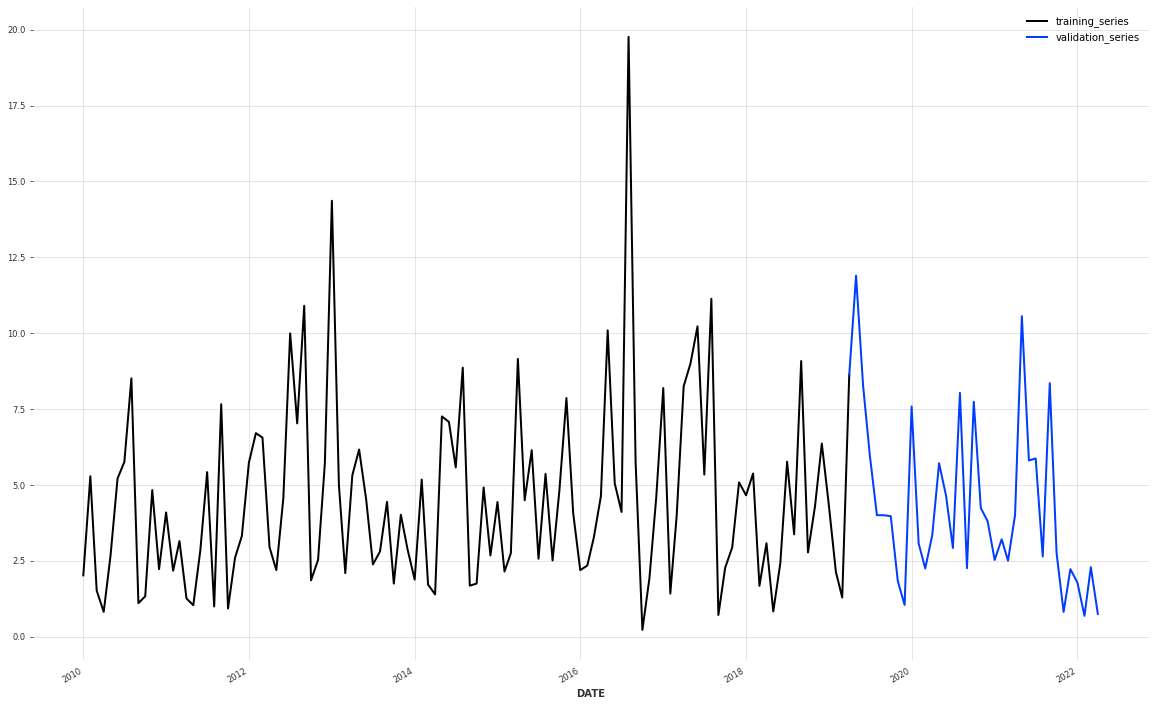

In [14]:
plt.figure(figsize=(20,12))
train_series.plot(label='training_series')
val_series.plot(label='validation_series')
plt.legend()

## Exponential Smoothing Model

In [15]:
model = ExponentialSmoothing(random_state=42)
model.fit(train_series)
prediction = model.predict(len(val_series), num_samples=2000)

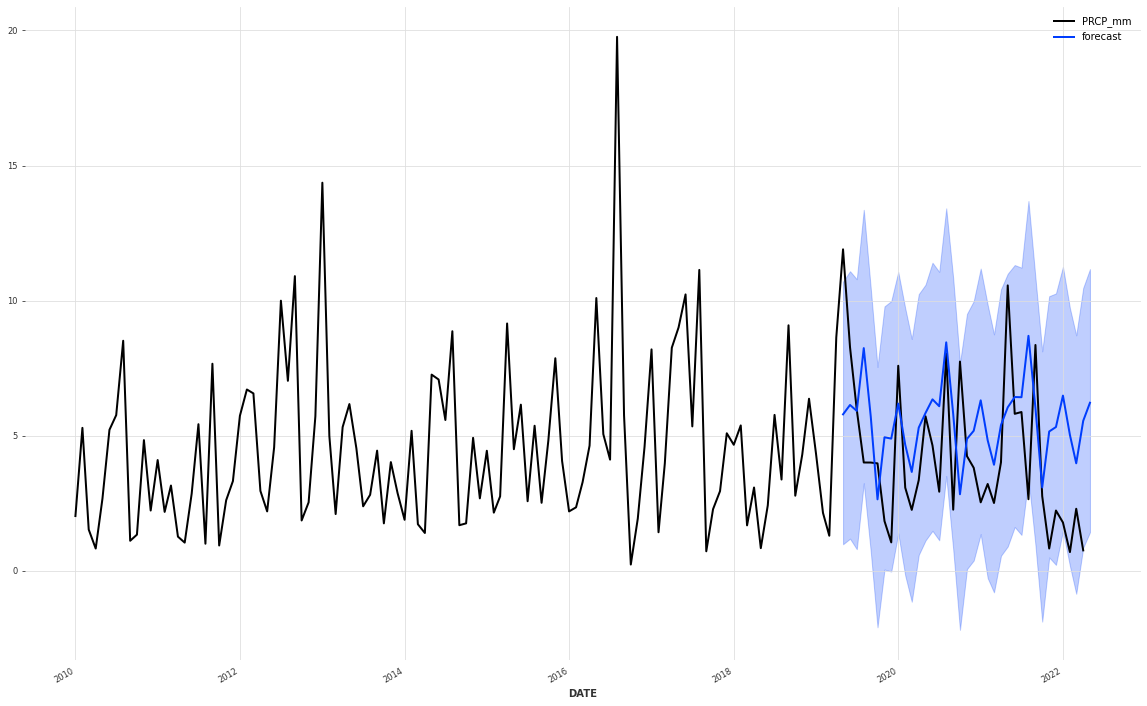

In [16]:
plt.figure(figsize=(20,12))
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [17]:
mse(val_series, prediction)

9.170352770757967

## ARIMA Model

In [18]:
model = ARIMA(random_state=42)
model.fit(train_series)
prediction = model.predict(len(val_series), num_samples=40)

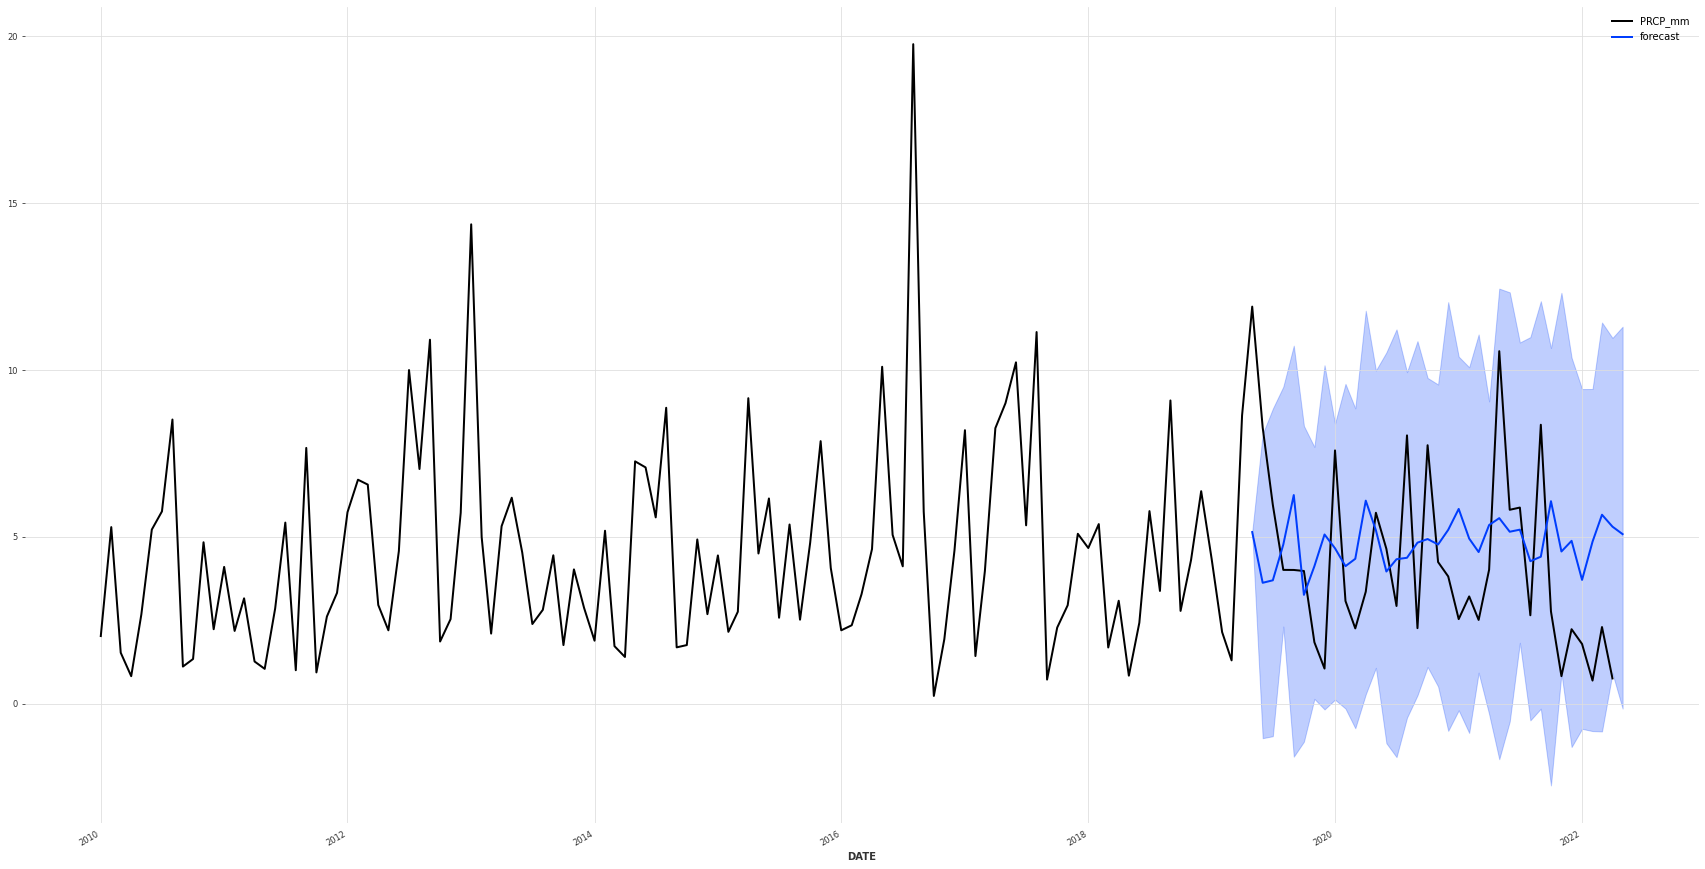

In [19]:
plt.figure(figsize=(30,15))
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [20]:
mse(val_series, prediction)

8.422188182532027

## Normalizing the series for NN

In [21]:
check_seasonality(series, max_lag=12)

(True, 5)

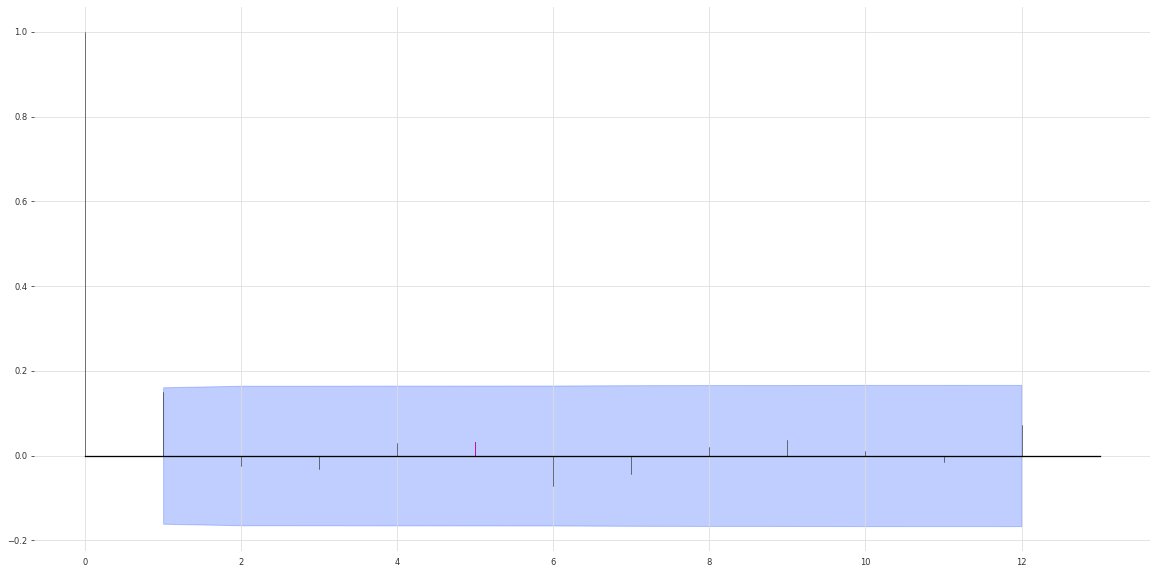

In [22]:
plot_acf(series, 5, max_lag=12, fig_size=(20, 10))

## Recurrent Neural Network (RNN) Model

In [23]:
# Normalize time series for RNN exceution
transformer = Scaler()
train_transformed = transformer.fit_transform(train_series)
val_transformed = transformer.transform(val_series)
series_transformed = transformer.transform(series)

In [24]:
max(train_transformed.pd_dataframe().index)

Timestamp('2019-04-01 00:00:00', freq='MS')

In [25]:
# Create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(max(train_transformed.pd_dataframe().index))

In [26]:
rnn_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Precipitation_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

In [27]:
rnn_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=False,
)

In [28]:
def eval_model(model):
    pred_series = model.predict(n=37, future_covariates=covariates)
    plt.figure(figsize=(30, 15))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.3f}%".format(mape(pred_series, val_transformed)))
    print("MSE:{:.3f}".format(mse(pred_series, val_transformed)))
    plt.legend()

MSE:0.057


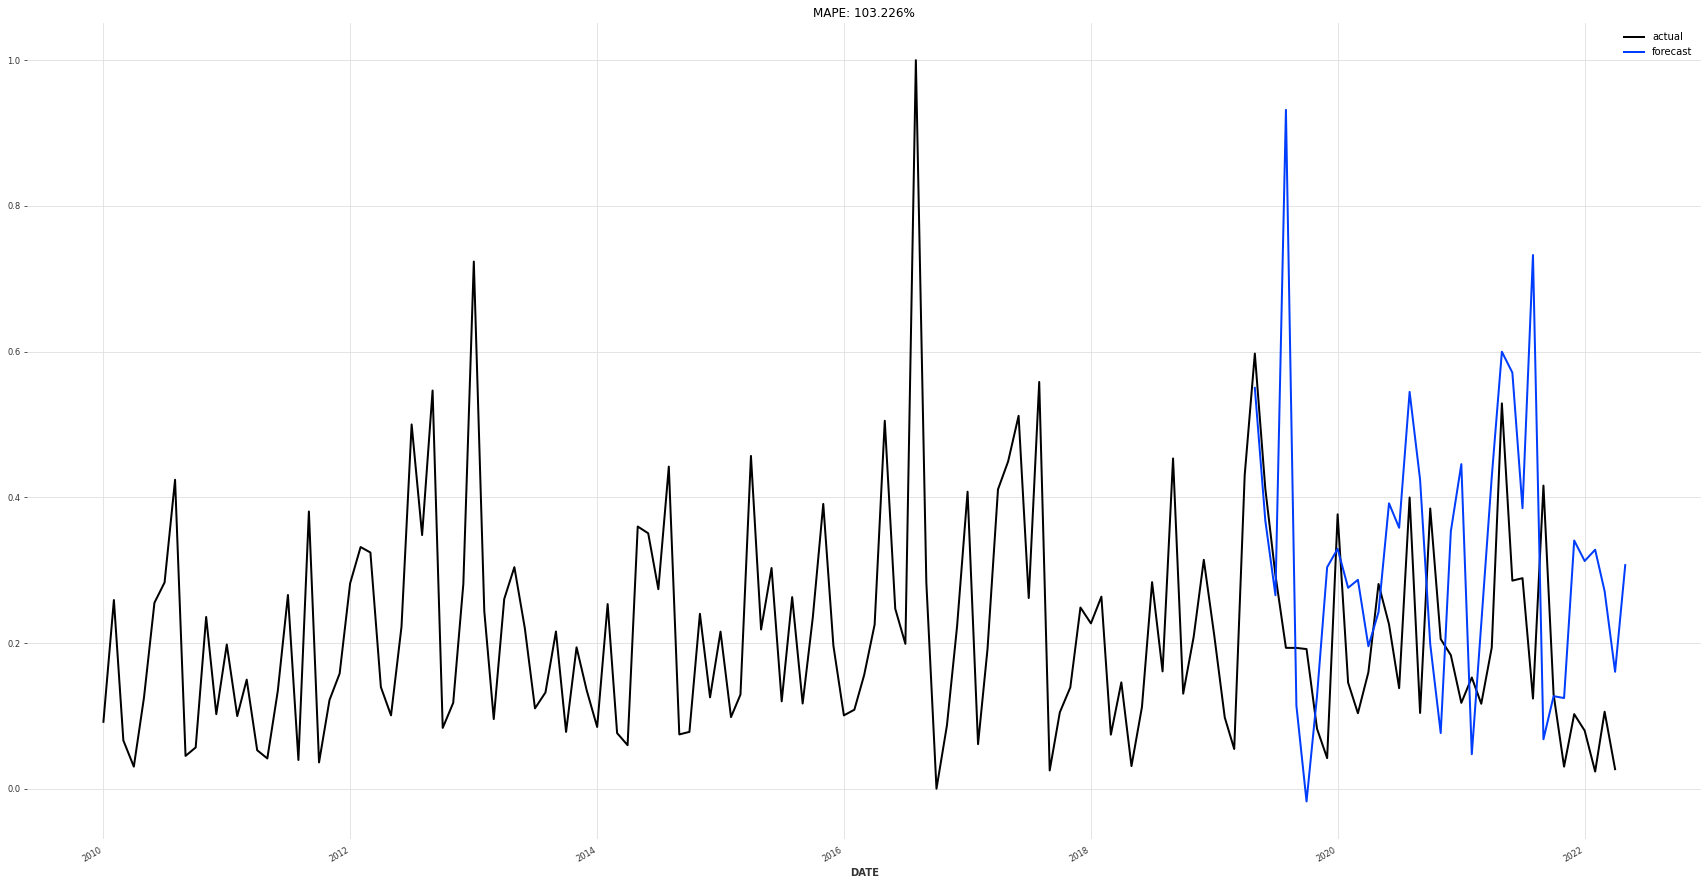

In [29]:
eval_model(rnn_model)

In [30]:
backtest_series = rnn_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates,
    start=max(train_transformed.pd_dataframe().index),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

  0%|          | 0/32 [00:00<?, ?it/s]

MAPE: 116.63%


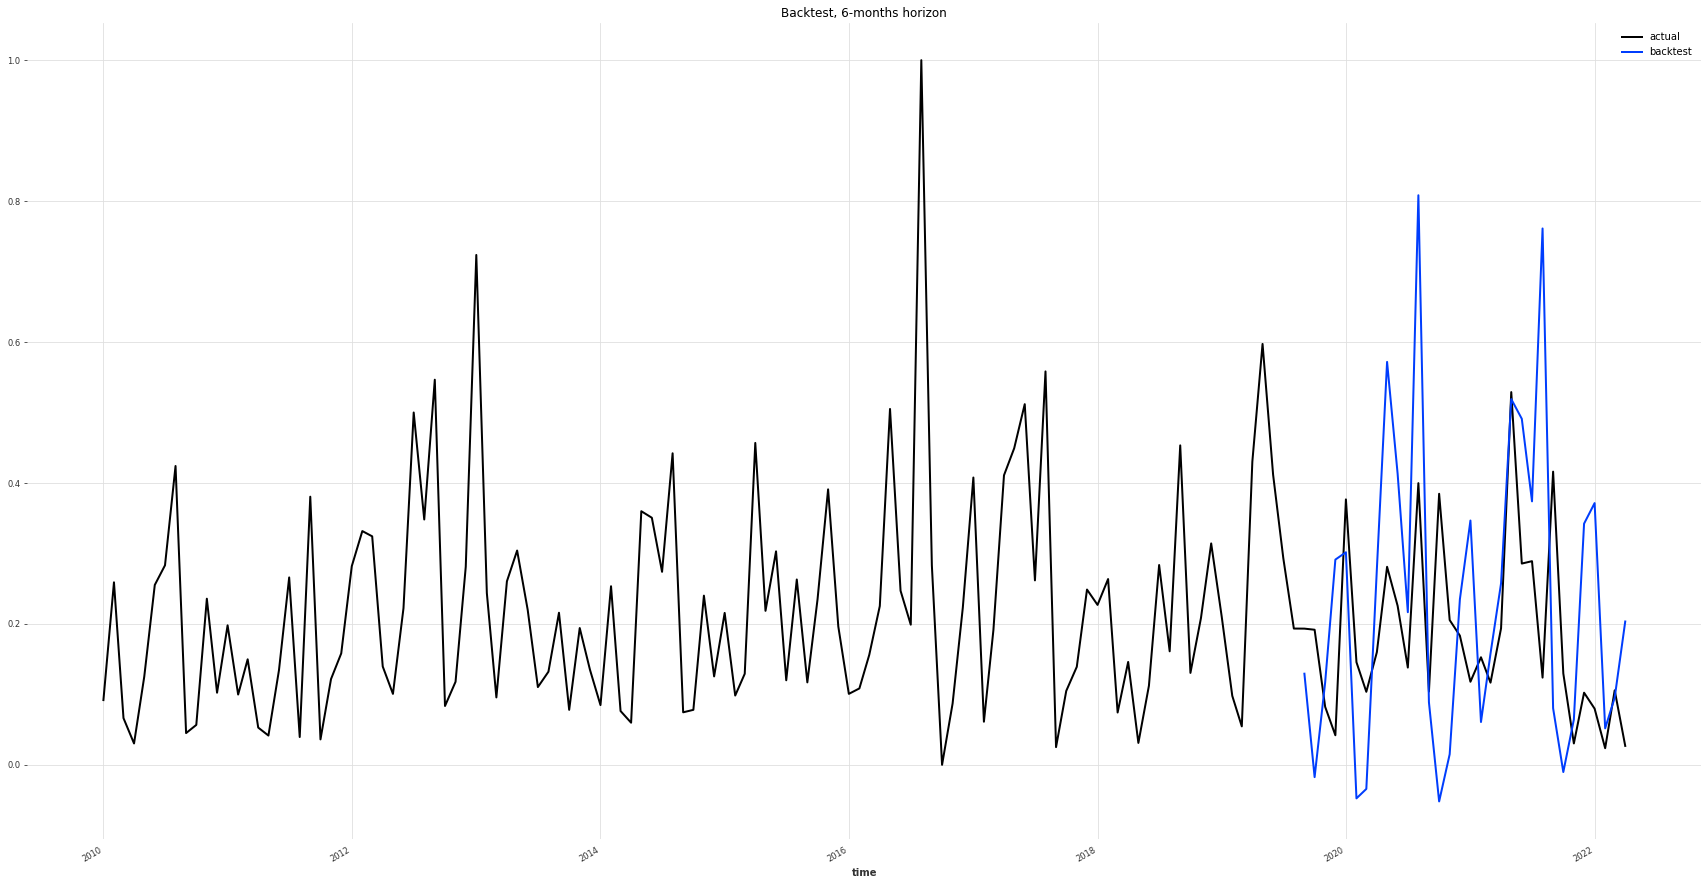

In [31]:
plt.figure(figsize=(30, 15))
series_transformed.plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest, 6-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_series),
        )
    )
)

## Temporal Fusion Transformer (TFT) Model

In [32]:
# Constant Parameters
num_samples = 200

figsize = (30, 15)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [33]:
# Normalize time series for RNN exceution
transformer = Scaler()
train_transformed = transformer.fit_transform(train_series)
val_transformed = transformer.transform(val_series)
series_transformed = transformer.transform(series)

In [34]:
max(train_transformed.pd_dataframe().index)

Timestamp('2019-04-01 00:00:00', freq='MS')

In [35]:
# Create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

training_cutoff = max(train_transformed.pd_dataframe().index)

# Transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [36]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 12
tft_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [37]:
tft_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Training: 0it [00:00, ?it/s]

In [38]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()
    return pred_series

Predicting: 5it [00:00, ?it/s]

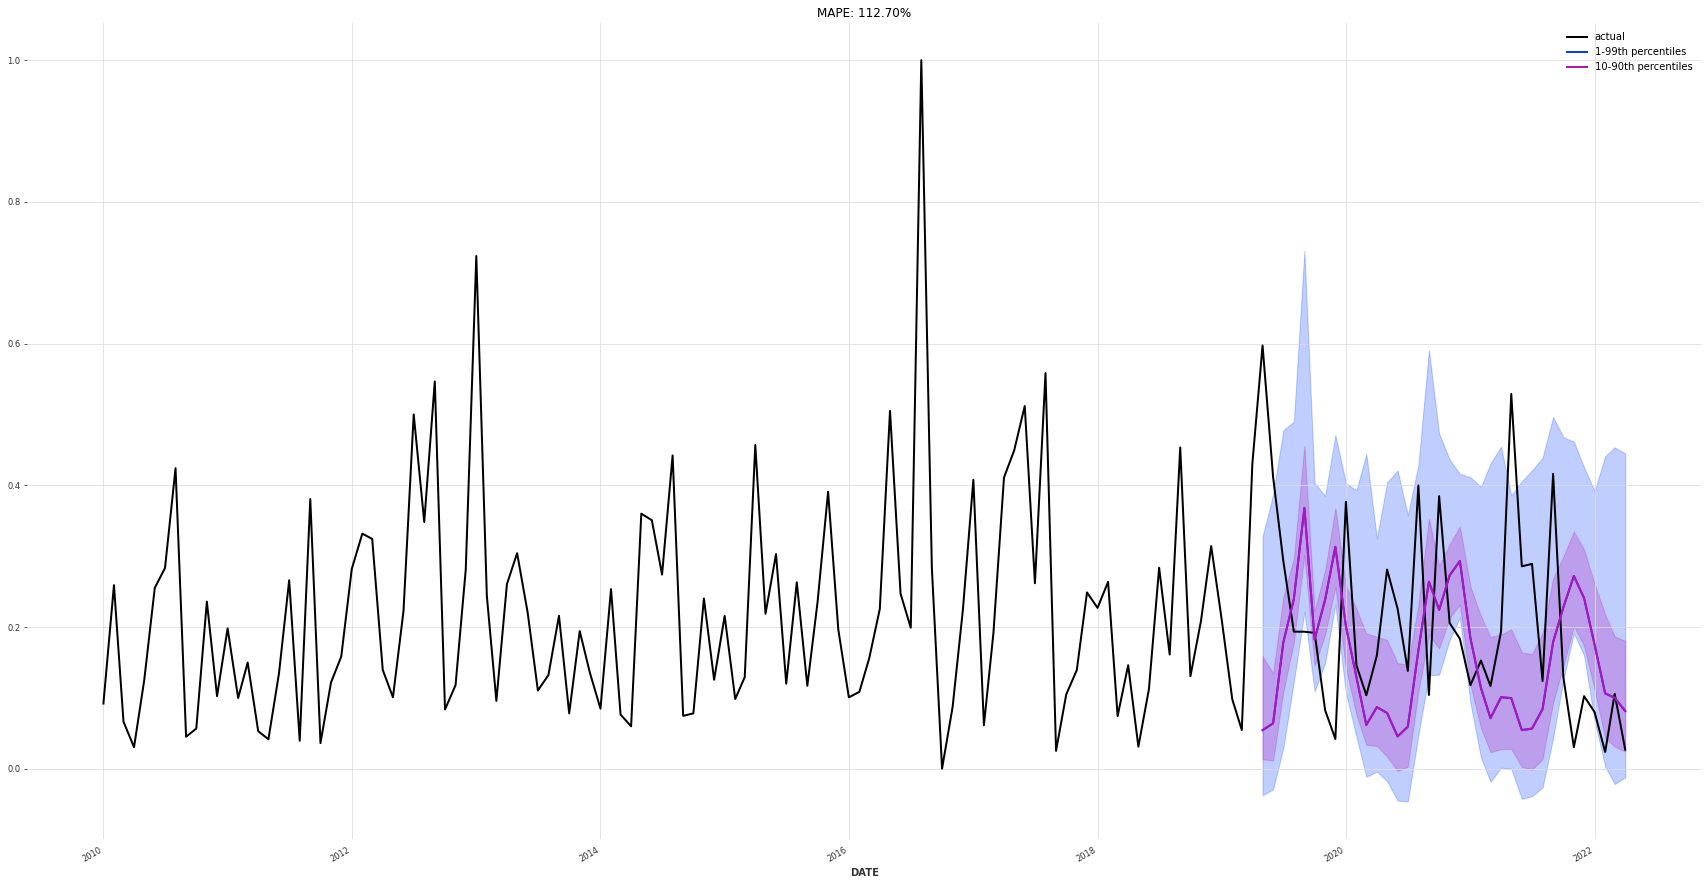

In [39]:
pred_series = eval_model(tft_model, 36, series_transformed, val_transformed)

In [40]:
print("MSE:{:.3f}".format(mse(pred_series, val_transformed)))
print("MAPE: {:.3f}%".format(mape(pred_series, val_transformed)))

MSE:0.035
MAPE: 146.473%
